# TUTORIAL: Real-time bias-aware data assimilation
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

* [What is bias-aware data assimilation?](#BADA)
    * [The source of bias: model accuracy vs computational cost](#source)
    * [Algorithmic view on bias-aware data assimilation](#algo)
* [What is bias-aware data assimilation, a bit more technically?](#tech)
    * [Aleatoric and epistemic uncertainties](#UQ)
    * [Augmented state-space formulation](#augment)
    * [Model bias in a stochastic ensemble framework](#bias-stoch)
    * [How do we estimate the bias in time?](#evolution)
* [The regularized ensemble Kalman filter](#rEnKF)
    * [Test case: van der Pol model with manually added bias](#test)
 


<a class="anchor" id="BADA"></a>
# 1. What is bias-aware data assimilation? 
Real-time data assimilation combines quick estimates of a physical state from an numerical model with experimental data.  In reality, numerical models are not a perfect representation of the physical quantity which we aim to predict because they typically rely on assumptions and simplifications for computational, i.e, they have an inherent model bias.

<br /> 

<a class="anchor" id="source"></a>
## 1.1. The source of bias: model accuracy vs computational cost 

The choice of physical model plays a key role in the assimilation. Numerical models are mathematical representations of the processes that govern the behaviour of a physical system. For example, in weather forecasting, models simulate how the atmosphere evolves over time based on physical equations describing fluid dynamics, thermodynamics, etc. The more physical information we add to the model, the higher the accuracy of the model estimates. However, the computational requirements increase with the model complexity.

To perform real-time data assimilation we need quick estimates of the physical system. Thus, performing real-time high-fidelity modelling is not plausible in realistic scenarios. In order to apply real-time data assimilation to low-fidelity models, we must provide an estimate of the bias in the numerical model, i.e., the model error that we introduce when simplifying the physical equations.  


<a><img src="https://magrilab.ae.ic.ac.uk/uploads/9/6/2/1/96210914//pyramid_1.png"></a>



<a class="anchor" id="algo"></a>
## 1.2. Algorithmic view on bias-aware data assimilation 

Algorithmically, we can summarize the bias-aware data assimilation process as:
1. <em>Forecast</em>: propagate the imperfect numerical model in time to provide a <strong><font color="#e0915c">biased forecast</font></strong> when <strong><font color="#24678d">observation</font></strong> data become available.
2. <em>Bias correction</em>: provide an estimate the bias, and project the <strong><font color="#e0915c">biased forecast</font></strong> into an <strong><font color="#a561d0">unbiased forecast</font></strong><font color="#2a2a2a"></font>. 
3. <em>Assimilation</em>: combine optimally the <strong><font color="#a561d0">unbiased forecast</font></strong> with the <strong><font color="#24678d">observations</font></strong>. The direct assimilation results in an <strong><font color="#91e05c">unbiased analysis</font></strong>, and the <strong><font color="#76cae9">biased analysis</font></strong> is an indirect by-product of the assimilation.
4. <em>Update</em>: the <strong><font color="#76cae9">biased analysis</font></strong> is the initial condition for the new forecast step.

<a><img src="https://magrilab.ae.ic.ac.uk/uploads/9/6/2/1/96210914//wbada-4_1.gif   "></a> 

<br /> 

<a class="anchor" id="tech"></a>
# 2. What is bias-aware data assimilation, a bit more technically? 

In this section, we revisit the formulation of the stochastic framework introduced in tutorial ***10_DA_intro_twin_VdP.ipynb*** and we extend it to account for model biases. 

<br />
<a class="anchor" id="UQ"></a>
## 2.1. Aleatoric and epistemic uncertainties  
 

First, we discuss the statistical hypotheses on the aleatoric uncertainties. The aleatoric uncertainties contaminate the state and parameters as 
$$
\begin{equation}
     \boldsymbol{\phi}  +  \boldsymbol{\epsilon}_\phi =  \boldsymbol{\phi}^\dagger, \quad
     \boldsymbol{\alpha} +  \boldsymbol{\epsilon}_\alpha =  \boldsymbol{\alpha}^\dagger,
\end{equation}
$$
where $\dagger$ indicates the true quantity (which is unknown). The aleatoric uncertainties are modelled as Gaussian distributions   
$$
\begin{equation}
     \boldsymbol{\epsilon}_\phi \sim \mathcal{N}( \mathbf{0},  \mathbf{C}_{\phi\phi} ), \quad  \boldsymbol{\epsilon}_\alpha \sim \mathcal{N}( \mathbf{0},  \mathbf{C}_{\alpha\alpha} ),
\end{equation}
$$
where $\mathcal{N}( \mathbf{0},  \mathbf{C})$ is a normal distribution with zero mean and covariance $ \mathbf{C}$. Second, we discuss model biases, which are epistemic uncertainties. The model bias is defined as the expected difference between the true observable and the model observable, i.e., 
$$
\begin{equation} 
   \mathbf{b}   =  \mathbf{d}^{\dagger} -\mathbb{E}( \mathbf{q}). 
\end{equation}
$$
Hence, the bias-corrected model observable is
$$
\begin{equation} 
     \mathbf{y} =  \mathbf{q} +  \mathbf{b} +  \boldsymbol{\epsilon}_q, 
\end{equation}
$$
where $  \boldsymbol{\epsilon}_q \sim \mathcal{N}( \mathbf{0},  \mathbf{C}_{qq})$. (If the model is unbiased, $ \mathbf{d}^{\dagger} =\mathbb{E}( \mathbf{q})$.) 


The final model equations, which define the first source of information on the system, are
$$
\begin{align} 
\left\{
\begin{array}{rcl}
      \mathrm{d} \boldsymbol{\phi}&=& \mathcal{F}\left( \boldsymbol{\phi+ \boldsymbol{\epsilon}_\phi, \alpha+ \boldsymbol{\epsilon}_\alpha} \right)  \mathrm{d} t \\
       \mathbf{y} &=& \mathcal{M}( \boldsymbol{\theta},  \boldsymbol{\phi}) +  \mathbf{b}+  \boldsymbol{\epsilon}_q
\end{array}
\right.
\end{align}
$$
This set of equations is not closed because we need a model for the model bias. To infer it, we analyse  the residuals between the forecast and the observations, which are also known as <em>innovations<em/>
$$
\begin{equation}
    \mathbf{i} =  \mathbf{d} -  \mathbf{q}. 
\end{equation}
$$
As discussed in tutorial ***10_DA_intro_twin_VdP.ipynb***, the experimental data are affected by aleatoric noise such that $\mathbf{d} + \boldsymbol{\epsilon}_d =  \mathbf{d}^{\dagger}$, where  $\boldsymbol{\epsilon}_d \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{dd})$ and  $\mathbf{C}_{dd}$ is a diagonal matrix with diagonal $\boldsymbol{\epsilon}_d$. With this, the expected value of the innovation is 
$$
\begin{equation}
    \mathbb{E}( \mathbf{i}) =  \mathbf{b}, 
\end{equation}
$$
i.e., the expected innovation is the model bias. 


<br />




## 2.2. Augmented state-space formulation <a class="anchor" id="augment"></a>
The augmented form of the state-space formulation of the model, accounting for th emodel bias, yields 
$$
\begin{align}
\left\{
\begin{array}{rcl}
      \mathrm{d}\begin{bmatrix}
      \boldsymbol{\phi}\\
      \boldsymbol{\alpha}\\
      \mathbf{q}
 \end{bmatrix} &=& 
 \begin{bmatrix}
     \mathcal{F}( \boldsymbol{\phi}+ \boldsymbol{\epsilon}_\phi, \boldsymbol{\alpha}+ \boldsymbol{\epsilon}_\alpha)\\
      \mathbf{0}_{N_\alpha}\\
      \mathbf{0}_{N_q}
 \end{bmatrix} 
{ \mathrm{d} t}  \\
 \mathbf{y} &=&  \mathbf{q} +  \mathbf{b}  +  \boldsymbol{\epsilon}_{q}
\end{array}
\right.
\quad\leftrightarrow  \quad
\left\{
\begin{array}{rcl}
 \mathrm{d} \boldsymbol{\psi} &=&  \mathbf{F}\left( \boldsymbol{\psi} + \boldsymbol{\epsilon}_\psi\right){ \mathrm{d} t}  \\
 \mathbf{y} &=&  \mathbf{M} \boldsymbol{\psi} +  \mathbf{b}  +  \boldsymbol{\epsilon}_{q}
\end{array}
\right.
\end{align}
$$
where $\mathbf{F}( \boldsymbol{\psi})$ and $ \boldsymbol{\epsilon}_\psi$ are the augmented nonlinear operator and aleatoric uncertainties, respectively; $ \mathbf{M} = \left[ \mathbf{0}~\big|~\mathbb{I}_{N_q}\right]$ is the linear measurement operator; and $ \mathbf{0}_{N_\alpha}$ and $ \mathbf{0}_{N_q}$ are vectors of zeros (because the parameters are constant in time, and $ \mathbf{q}$ is not integrated in time but it is only computed at the analysis step).  

<br />

## 2.3. Model bias in a stochastic ensemble framework <a class="anchor" id="bias-stoch"></a>
The underlying assumption of ensemble methods is that the ensemble is Gaussian distributed, i.e,  $ \boldsymbol{\psi}_j\sim\mathcal{N}(\bar{ \boldsymbol{\psi}},  \mathbf{C}_{\psi\psi})$. Within an ensemble framework, we approximate the model bias  with the ensemble statistics  
$$
\begin{align}
     \mathbf{b} &\approx \mathbf{d}^{\dagger} -  \mathbf{M}\bar{ \boldsymbol{\psi}}, 
\end{align}
$$
Hence, the innovation of the ensemble mean can be approximated as 
$$
\begin{equation}
    \bar{ \mathbf{i}} =  \mathbf{d} -  \mathbf{M}\bar{ \boldsymbol{\psi}} \approx  \mathbf{b}.  
\end{equation}
$$


___

#### Exercise 
<em><font color=#7CB9E8> 
<emsp> How does the definition of the innovaition change is we did not assume unbiased observations? This is, $\mathbb{E}(\mathbf{d}) \neq  \mathbf{d}^{\dagger}$.
<br />

___

<a class="anchor" id="evolution"></a>
## 2.4. How do we estimate the bias in time? 

The model bias is defined as  is the expected difference between the true observable and the model observable. Therefore, it is unknown a priori (colloquially, it is an <em>unknown unknown</em>).  The model bias may be a function of the physical state, the environment or even a function of time. 


Recent advances in machine learning for data-driven modelling allow us to develop surrogate models of dynamical systems using neural networks. This is, we can use a neural network to estimate the bias of the low-order numerical models. Specifically, we employ an echo state network (ESN) to infer the model bias.  ESNs are suitable for real-time data assimilation because 
1. they are recurrent neural networks, i.e., they are designed to learn temporal dynamics in data; 
2. they are based on reservoir computing, hence they are universal approximators;
3. they are general nonlinear auto-regressive models; and 
4. training an ESN consists of solving a linear regression problem, which provides a global minimum without backpropagation.

The architecture of the model bias estimation by ESN is illustrated below. The network can evolve in open-loop (left) when observations are available or in closed-loop (right), in which the ESN runs autonomously. 


<a><img src="https://magrilab.ae.ic.ac.uk/uploads/9/6/2/1/96210914//esn-web_1.png"></a> 







<a class="anchor" id="rEnKF"></a>
# 3. The bias-regularized ensemble Kalman filter 

The objective function in a bias-regularized data assimilation framework contains three norms
$$
\begin{align}
\mathcal{J}( \boldsymbol{\psi}_j) = &\left\| \boldsymbol{\psi}_j- \boldsymbol{\psi}_j^\mathrm{f}\right\|^2_{ \mathbf{C}^{\mathrm{f}^{-1}}_{\psi\psi}} +
 \left\|{ \mathbf{y}}_j- \mathbf{d}_j\right\|^2_{\mathbf{C}^{-1}_{dd}}+\gamma\left\| \mathbf{b}_j\right\|^2_{ \mathbf{C}^{-1}_{bb}}, \quad \mathrm{for} \quad j=0,\dots,m-1
\end{align}
$$
where the superscript 'f' indicates 'forecast'; the operator $\left\|\cdot\right\|^2_{ \mathbf{C}^{-1}}$ is the $L_2$-norm weighted by the semi-positive definite matrix ${ \mathbf{C}^{-1}}$; $\gamma\geq0$ is a user-defined bias regularization factor; and $ \mathbf{b}_j$ is the model bias of each ensemble member. For simplicity, we define the bias in the ensemble mean, such that  $ \mathbf{b}_j =  \mathbf{b}$ for all $j$. From left to right, the norms on the right-hand-side of the cost fuction measure 
1. the spread of the ensemble prediction, 
2. the distance between the bias-corrected estimate and the observables, and 
3. the model bias norm.

The analytical solution of the bias-regularized ensemble Kalman filter (r-EnKF), which globally minimizes the cost function with respect to $ \boldsymbol{\psi}_j$, is 
$$
\begin{align}
     \boldsymbol{\psi}_j^\mathrm{a} &= 
     \boldsymbol{\psi}_j^\mathrm{f} + 
     \mathbf{K}_\mathrm{r} \left[\left(\mathbb{I}+  \mathbf{J}\right)\left( \mathbf{d}_j -  \mathbf{y}_j^\mathrm{f}\right) - \gamma  \mathbf{C}_{dd} \mathbf{C}^{-1}_{bb} \mathbf{J} \mathbf{b}^\mathrm{f}\right], \quad j=0,\dots,m-1
\end{align}
$$
with
$$
\begin{align}
 \mathbf{K}_\mathrm{r} =  \mathbf{C}_{\psi\psi}^\mathrm{f} \mathbf{M}^\mathrm{T}\left[ \mathbf{C}_{dd} + (\mathbb{I}+  \mathbf{J}) \mathbf{M} \mathbf{C}_{\psi\psi}^\mathrm{f} \mathbf{M}^\mathrm{T}(\mathbb{I}+  \mathbf{J})^\mathrm{T} + \gamma  \mathbf{C}_{dd} \mathbf{C}^{-1}_{bb} \mathbf{J} \mathbf{M} \mathbf{C}_{\psi\psi}^\mathrm{f} \mathbf{M}^\mathrm{T}{ \mathbf{J}}^\mathrm{T}\right]^{-1},
\end{align}
$$
where 'a'  stands for 'analysis', i.e, the optimal state of the assimilation; $ \mathbf{K}_\mathrm{r}$ is the regularized Kalman gain matrix; and $ \mathbf{J} =  \mathrm{d}  \mathbf{b}/ \mathrm{d} \mathbf{M} \boldsymbol{\psi}$ is the Jacobian of the bias estimator. We prescribe  $ \mathbf{C}_{dd} =  \mathbf{C}_{bb}$ because the model  bias is defined in the observable space.  We use $\gamma$ to tune the norm of the bias. The optimal state and parameters are
 $$
\begin{align}
    \begin{bmatrix}
         \boldsymbol{\phi}_j^\mathrm{a}\\
         \boldsymbol{\alpha}_j^\mathrm{a}
    \end{bmatrix}
    = 
    \begin{bmatrix}
         \boldsymbol{\phi}_j^\mathrm{f}\\
         \boldsymbol{\alpha}_j^\mathrm{f}
    \end{bmatrix} + 
    \overbrace{
    \begin{bmatrix}
         \mathbf{C}_{\phi q}^\mathrm{f}\\
         \mathbf{C}_{\alpha q}^\mathrm{f}
    \end{bmatrix}
        \left\{ \mathbf{C}_{dd}+(\mathbb{I}+  \mathbf{J}) \mathbf{C}_{qq}^\mathrm{f}(\mathbb{I}+  \mathbf{J})^\mathrm{T} +\gamma  \mathbf{J} \mathbf{C}_{qq}^\mathrm{f}{ \mathbf{J}}^\mathrm{T}\right\}^{-1}
    }^\mathrm{Regularized\, Kalman \, gain,\,  \mathbf{K}_\mathrm{r}} \Big[\left(\mathbb{I}+\mathbf{J}\right)\left(\mathbf{d}_j -  \mathbf{y}_j^\mathrm{f}\right)- \gamma  \mathbf{J} \mathbf{b}^\mathrm{f}\Big]
\end{align}
$$
The r-EnKF defines a `good' analysis from a biased model if  the unbiased state $ \mathbf{y}$ matches the truth, and the model bias $ \mathbf{b}$ is small relative to the truth. The underlying assumptions of this work are that (i) our low-order model is qualitatively accurate such that the model bias $ \mathbf{b}^\mathrm{f}$ has a small norm; and (ii) the sensors are properly calibrated.

<br />

___

    
#### Exercise
<em><font color=#7CB9E8> Proof that in the limiting case when the assimilation framework is unbiased, the r-EnKF becomes the bias-unregularized EnKF, which we discussed in the previous tutorials.
</font>
<br />

___


In [4]:
import scipy.linalg as la 
def rBA_EnKF(Af, d, Cdd, Cbb, k, M, b, J):
    """ Bias-aware Ensemble Kalman Filter.
        Inputs:
            Af: forecast ensemble at time t (augmented with Y) [N x m]
            d: observation at time t [Nq x 1]
            Cdd: observation error covariance matrix [Nq x Nq]
            Cbb: bias covariance matrix [Nq x Nq]
            k: bias penalisation factor
            M: matrix mapping from state to observation space [Nq x N]
            b: bias of the forecast observables (Y = MAf + B) [Nq x 1]
            J: derivative of the bias with respect to the input [Nq x Nq]
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """
    m = np.size(Af, 1)
    Nq = len(d)

    Iq = np.eye(Nq)
    # Mean and deviations of the ensemble
    Psi_f = Af - np.mean(Af, 1, keepdims=True)
    S = np.dot(M, Psi_f)
    Q = np.dot(M, Af)

    # Create an ensemble of observations
    D = rng.multivariate_normal(d, Cdd, m).transpose()

    # Correct the model estimate with the bias
    Y = Q + b

    Cqq = np.dot(S, S.T)  # covariance of observations M Psi_f Psi_f.T M.T
    if np.array_equiv(Cdd, Cbb):
        CdWb = Iq
    else:
        CdWb = np.dot(Cdd, la.inv(Cbb))

    Cinv = ((m - 1) * Cdd + np.dot(Iq + J, np.dot(Cqq, (Iq + J).T)) + k * np.dot(CdWb, np.dot(J, np.dot(Cqq, J.T))))

    K = np.dot(Psi_f, np.dot(S.T, la.inv(Cinv)))
    Aa = Af + np.dot(K, np.dot(Iq + J, D - Y) - k * np.dot(CdWb, np.dot(J, np.repeat(b, m, axis=1))))

    return Aa


In [5]:
%matplotlib widget
import numpy as np

rng = np.random.default_rng(0)

<a id="test"></a>
## 3.1. Test case: van der Pol model with manually added bias 

In [7]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from essentials.physical_models import VdP
from essentials.create import create_truth
rng = np.random.default_rng(0)

dt_t = 2e-4


# The manual bias is a function of state and/or time
def manual_bias(y, t):
    # Linear function of the state
    return .2 * y + .3 * np.max(y, axis=0), 'linear'
    # Periodic function of the state
    # return 0.5 * np.max(y, axis=0) * np.cos(2 * y / np.max(y, axis=0)), 'periodic'
    # Time-varying bias
    # return .4 * y * np.sin((np.expand_dims(t, -1) * np.pi * 2) ** 2), 'time'


true_params = dict(model=VdP,
                   t_start=1.5,
                   t_stop=1.8,
                   t_max=2.5,
                   Nt_obs=30,
                   dt=dt_t,
                   psi0=rng.random(2)+5,
                   std_obs=0.1,
                   noise_type='gauss,additive',
                   manual_bias=manual_bias
                   )

truth = create_truth(**true_params)
y_obs, t_obs = [truth[key].copy() for key in ['y_obs', 't_obs']]



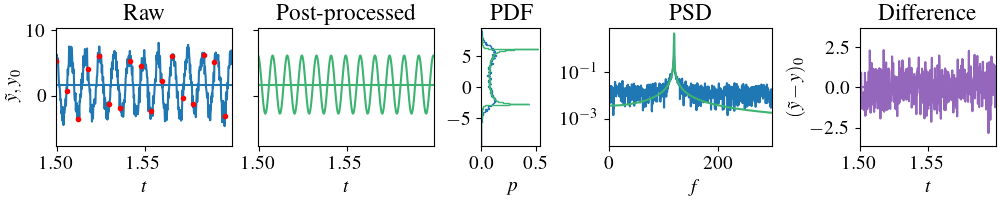

In [8]:
# Visualize the truth and observations
from essentials.plotResults import plot_truth
plot_truth(f_max=300, window=0.1, **truth)

### ii. Define ensemble

In [9]:
from essentials.create import create_ensemble

forecast_params = dict(filter='rBA_EnKF',
                       m=10,
                       dt=dt_t,
                       model=VdP,
                       est_a=dict(zeta=(40, 80.),
                                 beta=(50, 80),
                                 kappa=(3, 5),
                                 ),
                       std_psi=0.3,
                       alpha_distr='uniform',
                       inflation=1.0,
                       regularization_factor=0.
                       )


y_obs, t_obs = [truth[key].copy() for key in ['y_obs', 't_obs']]

ensemble = create_ensemble(**forecast_params)

### iii. Train an ESN to model the model bias
The procedure is the following:
- Initialise ESN Bias class object
- Create synthetic bias to use as training data 
- Train the ESN
- Create washout data


In [10]:
from essentials.create import create_bias_model
from essentials.bias_models import ESN


train_params = dict(bias_model=ESN, 
                    upsample=2,
                    N_units=40,
                    N_wash=10,
                    t_train=ensemble.t_CR * 5,
                    t_test=ensemble.t_CR * 1,
                    t_val=ensemble.t_CR * 1,
                    # Training data generation options
                    augment_data=True,
                    biased_observations=True,
                    L=20,
                    # Hyperparameter search ranges
                    rho_range=(0.4, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )

bias_model, wash_obs, wash_t = create_bias_model(ensemble, truth.copy(), bias_params=train_params)



ensemble.bias = bias_model.copy()


Rerun training data

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 4.000e-01	 1.000e-05	 1.000e-16	 -4.3430
2	 4.000e-01	 1.000e-03	 1.000e-16	 -3.8888
3	 4.000e-01	 1.000e-01	 1.000e-16	 -3.9303
4	 4.000e-01	 1.000e+01	 1.000e-16	 -3.7574
5	 6.000e-01	 1.000e-05	 1.000e-16	 -4.2341
6	 6.000e-01	 1.000e-03	 1.000e-16	 -2.1078
7	 6.000e-01	 1.000e-01	 1.000e-16	 -3.9634
8	 6.000e-01	 1.000e+01	 1.000e-16	 -3.8199
9	 8.000e-01	 1.000e-05	 1.000e-16	 -3.8628
10	 8.000e-01	 1.000e-03	 1.000e-16	 -2.0781
11	 8.000e-01	 1.000e-01	 1.000e-16	 -4.0185
12	 8.000e-01	 1.000e+01	 1.000e-16	 -3.8073
13	 1.000e+00	 1.000e-05	 1.000e-16	 -3.7635
14	 1.000e+00	 1.000e-03	 1.000e-16	 -3.0798
15	 1.000e+00	 1.000e-01	 1.000e-16	 -4.1442
16	 1.000e+00	 1.000e+01	 1.000e-16	 -2.3571
17	 4.687e-01	 1.326e-05	 1.000e-16	 -4.2129
18	 6.236e-01	 7.232e-01	 1.000e-16	 -4.2938
19	 7.720e-01	 6.549e-01	 1.000e-16

### iv. Run simulaiton

In [11]:
from essentials.DA import dataAssimilation

ensemble.regularization_factor = 5.
filter_ens = dataAssimilation(ensemble.copy(), y_obs=y_obs, t_obs=t_obs, std_obs=0.01, wash_t=wash_t, wash_obs=wash_obs)


 ------------------ VdP Model Parameters ------------------ 
	 Nq = 1
	 beta = 70.0
	 dt = 0.0002
	 gamma = 1.7
	 kappa = 4.0
	 law = tan
	 omega = 753.982
	 zeta = 60.0

 ---------------- ESN bias model parameters --------------- 
	 L = 20
	 N_ens = 1
	 N_units = 40
	 N_wash = 10
	 bayesian_update = False
	 biased_observations = True
	 connect = 3
	 observed_idx = [1]
	 perform_test = True
	 rho = 0.772003
	 sigma_in = 0.654891
	 t_train = 0.2
	 t_val = 0.04
	 tikh = 1e-16
	 update_reservoir = False
	 upsample = 2

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['zeta', 'beta', 'kappa'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'zeta': (40, 80.0), 'beta': (50, 80), 'kappa': (3, 5)}
 	 Number of analysis steps = 51, t0=1.4998, t1=1.7998
	 Bias penalisation factor k = 5.0

 --------------------------------------------


/Users/anovoama/anaconda3/envs/C-EnKF/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Elapsed time to first observation: 2.6355910301208496 s
Assimilation progress: 
	0 % 10% 20% 29% 39% 49% 59% 69% 78% 88% 100% ----------------

Elapsed time during assimilation: 2.3838441371917725 s


### v. Plot results

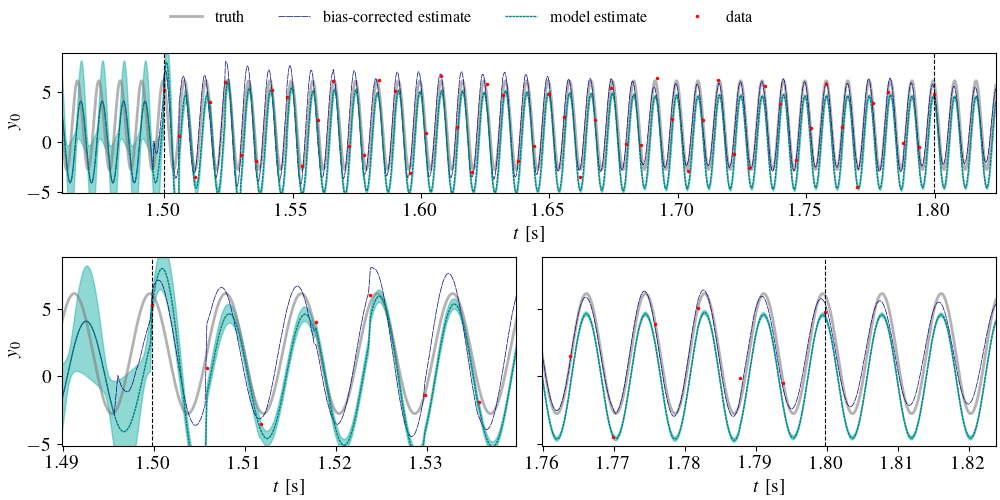

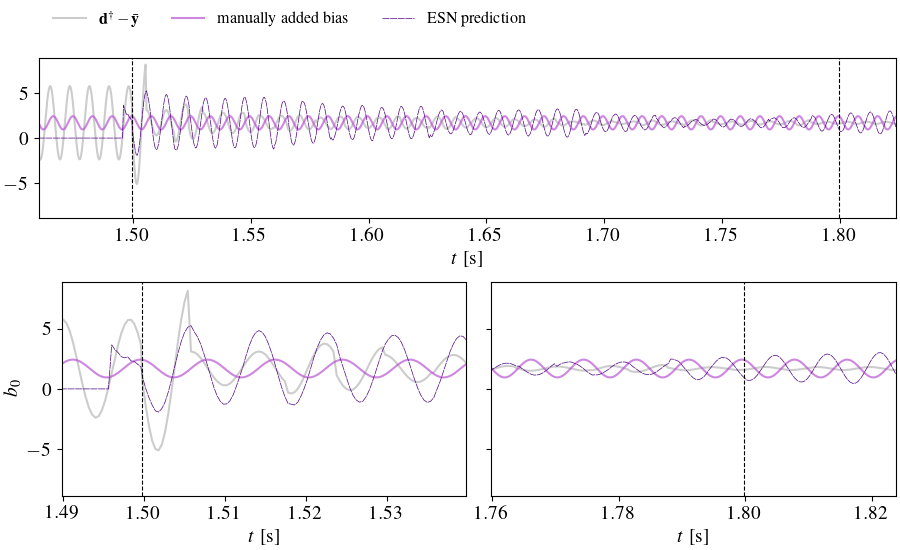

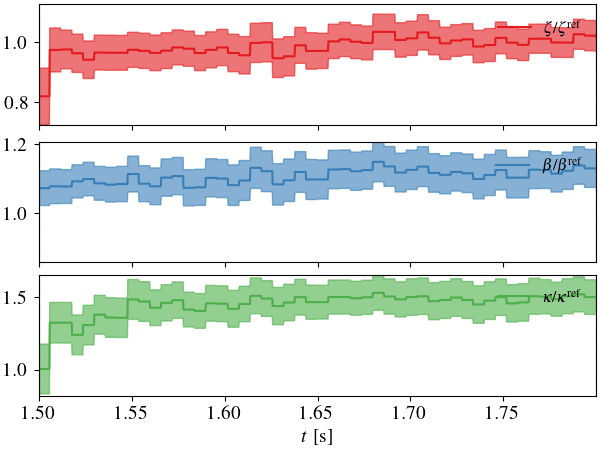

In [12]:
from essentials.plotResults import plot_timeseries, plot_parameters

# Visualize attractors
case0 = truth['case'].copy()
case1 = filter_ens.copy()

# Forecast the ensemble further without assimilation
ens = filter_ens.copy()

Nt = int(4 * true_params['Nt_obs'])
psi, t = ens.time_integrate(Nt, averaged=False)
ens.update_history(psi, t)

y = ens.get_observable_hist(Nt)
b, t_b = ens.bias.time_integrate(t=t, y=y)
ens.bias.update_history(b, t_b)


plot_timeseries(ens, truth.copy(), plot_ensemble_members=False, plot_bias=True)
plot_parameters(ens, truth.copy(), reference_p=VdP.defaults)



___

#### Exercise 
<em><font color=#7CB9E8> 
<emsp> How does the solution change as we vary the  bias regularization factor, $\gamma$ ? What happens if $\gamma=0$? And if  $\gamma=25$? 

___